In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

In [2]:
img = cv2.imread('./dataset/MariaSharapova/Sharapova_ (1).jpg')
img.shape

(612, 495, 3)

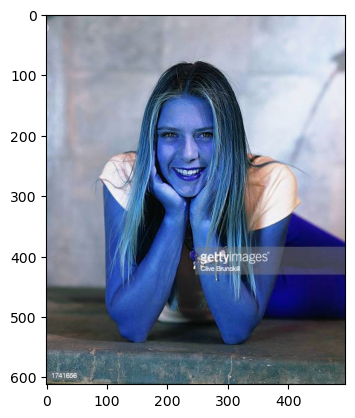

In [3]:
%matplotlib inline
plt.imshow(img)
plt.show()

In [4]:
gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

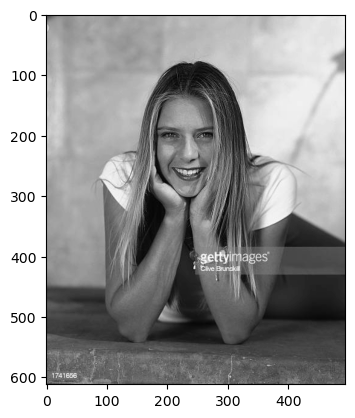

In [5]:
plt.imshow(gray,cmap='gray')
plt.show()

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[162, 146, 142, 142]])

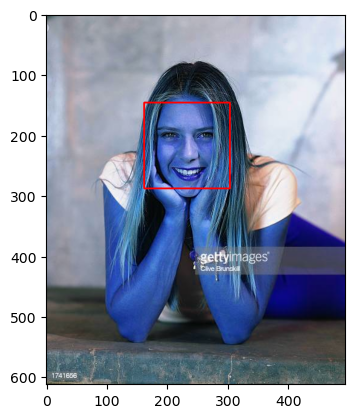

In [7]:
x,y,w,h = faces[0]
face_img = cv2.rectangle(img,(x,y),(x+w , y+h),(255,0,0),2)
plt.imshow(face_img)
plt.show()

In [8]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

    return None


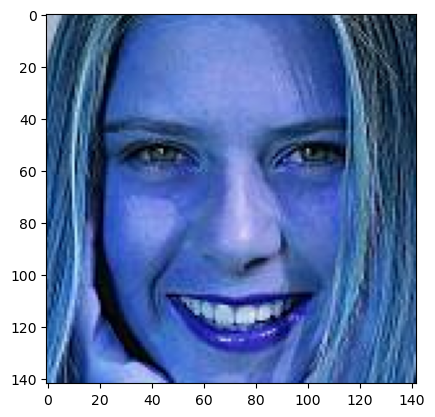

In [9]:
cropped_img = get_cropped_image_if_2_eyes('./dataset/MariaSharapova/Sharapova_ (1).jpg')
plt.imshow(cropped_img)
plt.show()

In [10]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [11]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [12]:
img_dirs

['./dataset/cropped',
 './dataset/Federer',
 './dataset/KobeBryant',
 './dataset/LionelMessi',
 './dataset/MariaSharapova',
 './dataset/Ronaldo',
 './dataset/Serena',
 './dataset/Virat']

In [13]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [14]:
cropped_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    print(celebrity_name)
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_dirs.append(cropped_folder)
                print("generating cropped images : " , cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
Federer
generating cropped images :  ./dataset/cropped/Federer
KobeBryant
generating cropped images :  ./dataset/cropped/KobeBryant
LionelMessi
generating cropped images :  ./dataset/cropped/LionelMessi
MariaSharapova
generating cropped images :  ./dataset/cropped/MariaSharapova
Ronaldo
generating cropped images :  ./dataset/cropped/Ronaldo
Serena
generating cropped images :  ./dataset/cropped/Serena
Virat
generating cropped images :  ./dataset/cropped/Virat


In [15]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

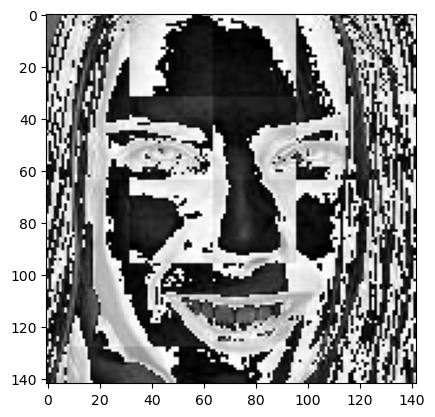

In [16]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')
plt.show()

In [17]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'cropped': 0,
 'Federer': 1,
 'KobeBryant': 2,
 'LionelMessi': 3,
 'MariaSharapova': 4,
 'Ronaldo': 5,
 'Serena': 6,
 'Virat': 7}

In [18]:
celebrity_file_names_dict.keys()

dict_keys(['cropped', 'Federer', 'KobeBryant', 'LionelMessi', 'MariaSharapova', 'Ronaldo', 'Serena', 'Virat'])

In [19]:
X= []
Y= []
for celebrity_name , training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_image = cv2.resize(img , (32 , 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har , (32,32))
        combined_img = np.vstack((scalled_raw_image.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))    
        X.append(combined_img)
        Y.append(class_dict[celebrity_name])
        

In [45]:
len(X[0])

4096

In [47]:
x = np.array(X).reshape(len(X),4096).astype(float)
x.shape

(118, 4096)

In [49]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [53]:
X_train , X_test , y_train , y_test = train_test_split(x,Y,test_size = 0.2)

In [55]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.4166666666666667

In [57]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.50      0.50      0.50         2
           4       0.50      0.11      0.18         9
           5       0.47      0.89      0.62         9
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.42        24
   macro avg       0.21      0.21      0.19        24
weighted avg       0.41      0.42      0.34        24



C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Siddharth\anaconda3\Lib\sit

In [59]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [73]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [75]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Siddharth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was depr

,model,best_score,best_params
0,svm,0.713450,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.510526,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.756725,{'logisticregression__C': 1}


In [85]:
best_estimators['logistic_regression'].score(X_test , y_test)

0.6666666666666666

In [89]:
best_clf = best_estimators['logistic_regression']

In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))

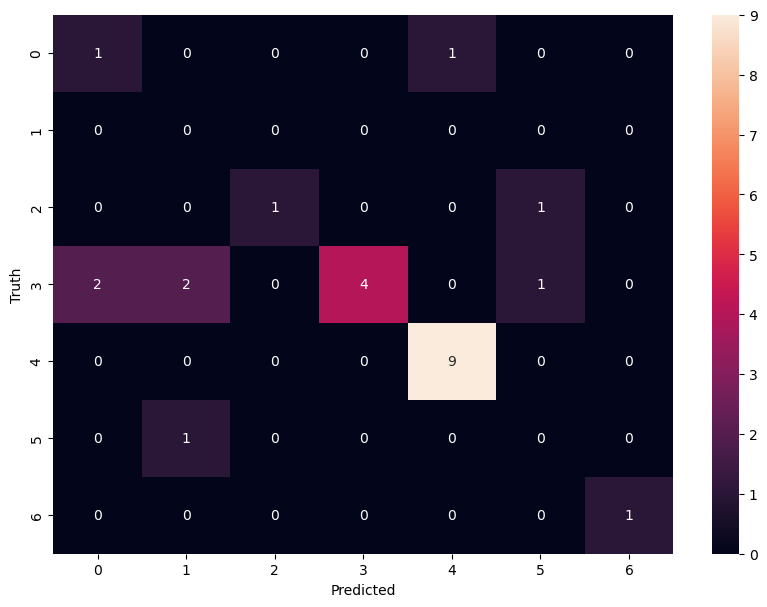

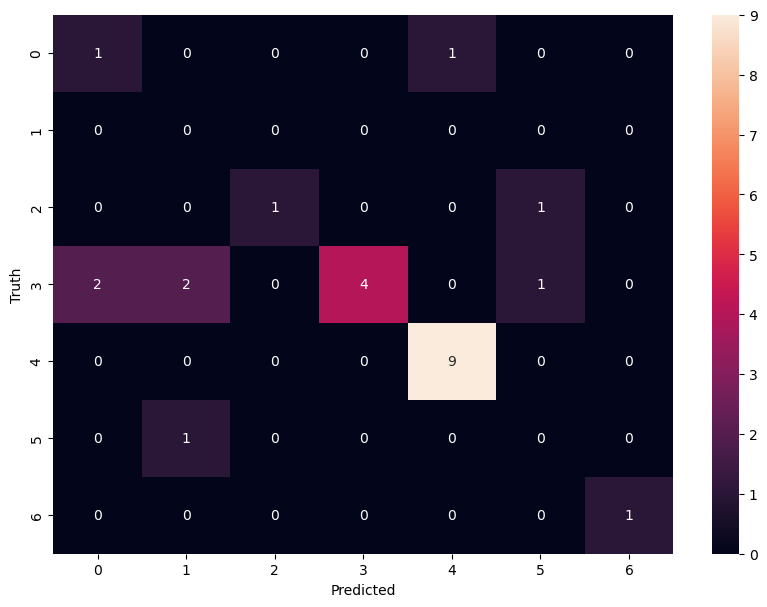

In [95]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [97]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [99]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [ ]:
5 